In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import tan,acos
import os
"""import matlab
import matlab.engine
def start_matlab():
    return matlab.engine.start_matlab()
def quit_matlab(matlab_engine):
    matlab_engine.quit()
    
def ieee_feeder_mapper(matlab_engine, IeeeFeeder):
    FeederMap, Z_in_ohm, Paths, NodeList, LoadList = matlab_engine.ieee_feeder_mapper(IeeeFeeder, nargout=5)
    FeederMap = np.array(FeederMap)
    Z_in_ohm = np.array(Z_in_ohm)
    Paths = np.array(Paths)
    NodeList = np.array(NodeList)
    LoadList = np.array(LoadList)
    return FeederMap, Z_in_ohm, Paths, NodeList[0], LoadList[0]-1"""

"""def FBSfun(matlab_engine, V0, loads, Z, B):
    V, _, S, _ = matlab_engine.FBSfun(float(V0), matlab.double(loads.tolist(),is_complex=True), matlab.double(Z.tolist(), is_complex=True), matlab.double(B.tolist(),is_complex=True), nargout=4)
    V = np.array(V, dtype=np.complex).squeeze()
    S = np.array(S, dtype=np.complex).squeeze()
    return V, S"""

#matlab_engine = start_matlab()  

LoadScalingFactor=2000
GenerationScalingFactor=50
SlackBusVoltage=1.02
power_factor=0.9
IncludeSolar=1

#Feeder parameters

LineNames = ('l_632_633','l_632_645','l_632_671','l_633_634','l_645_646','l_650_632','l_671_680','l_671_684',
             'l_671_692','l_684_611','l_684_652','l_692_675','l_u_650')

AllBusNames = ('sourcebus',
               'load_611','load_634','load_645','load_646','load_652','load_671','load_675','load_692',
               'bus_611','bus_634','bus_645','bus_646','bus_652','bus_671','bus_675','bus_692','bus_632',
               'bus_633','bus_650','bus_680','bus_684')

LoadBusNames = AllBusNames[1:9]
BusNames = AllBusNames[9:22]
IeeeFeeder = 13

LoadList = np.array([6,7,8,13,3,12,11,10])-1
NodeList = np.array([650,632,671,680,633,634,645,646,684,611,692,675,652])
BusesWithControl = NodeList[LoadList]

NumberOfLoads=len(LoadBusNames)
NumberOfNodes=len(BusNames)

#FeederMap, Z_in_ohm, Paths, _, _ = ieee_feeder_mapper(matlab_engine, IeeeFeeder)
FeederMap = np.array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.]])

Z_in_ohm = np.array([[0.00000000e+00+0.00000000e+00j],
       [1.31250000e-01+3.85568182e-01j],
       [1.31250000e-01+3.85568182e-01j],
       [6.56250000e-02+1.92784091e-01j],
       [7.12689394e-02+1.11875000e-01j],
       [1.42537879e-05+2.23750000e-05j],
       [1.25890152e-01+1.27566288e-01j],
       [7.55340909e-02+7.65397727e-02j],
       [7.52159091e-02+7.70965909e-02j],
       [7.55227273e-02+7.65625000e-02j],
       [1.42537879e-05+2.23750000e-05j],
       [7.55871212e-02+4.22632576e-02j],
       [2.03409091e-01+7.76363636e-02j]])

Paths = np.array([[ 1.,  2.,  3.,  4.,  0.],
       [ 1.,  2.,  5.,  6.,  0.],
       [ 1.,  2.,  7.,  8.,  0.],
       [ 1.,  2.,  3.,  9., 10.],
       [ 1.,  2.,  3., 11., 12.],
       [ 1.,  2.,  3.,  9., 13.]])

#Base value calculation
Vbase = 4.16e3 #4.16 kV
Sbase = 1.0 #500 kVA
Zbase = Vbase**2/Sbase
Ibase = Sbase/Vbase
Z = Z_in_ohm/Zbase

#Load Data Pertaining to Loads to create a profile
PV_Feeder_model = 10
FileDirectoryBase = 'C:\\Users\\Sy-Toan\\ceds-cigar\\LBNL_Simulations\\testpvnum10\\'
Time = list(range(1441))
TotalTimeSteps = len(Time)
QSTS_Data = np.zeros((TotalTimeSteps,4,IeeeFeeder))
for node in range(NumberOfLoads):
    FileDirectoryExtenstion = 'node_' + str(node+1) + '_pv_' + str(PV_Feeder_model) + '_minute.csv'
    FileName = FileDirectoryBase + FileDirectoryExtenstion
    MatFile = np.genfromtxt(FileName, delimiter=',')
    QSTS_Data[:,:,int(LoadList[node])] = MatFile

#Seperate PV Generation Data
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor
Load = QSTS_Data[:,3,:]*LoadScalingFactor
Generation = np.squeeze(Generation)/Sbase
Load = np.squeeze(Load)/Sbase
MaxGenerationPossible = np.max(Generation, axis=0)

#Voltage Observer Parameters and related variable initialization
LowPassFilterFrequency = 0.1
HighPassFilterFrequency = 1.0
Gain_Energy = 1e5
TimeStep = 1
FilteredOutput_vqvp = np.zeros((TotalTimeSteps,NumberOfNodes))
IntermediateOutput_vqvp= np.zeros((TotalTimeSteps,NumberOfNodes))
Epsilon_vqvp = np.zeros((TotalTimeSteps,NumberOfNodes))

#ZIP load modeling
ConstantImpedanceFraction = 0.2
ConstantCurrentFraction = 0.05
ConstantPowerFraction = 0.75
ZIP_demand = np.zeros((TotalTimeSteps,IeeeFeeder,3), dtype=np.complex)

for node in range(1,IeeeFeeder):
    ZIP_demand[:,node,:] = np.array([ConstantPowerFraction*Load[:,node].astype(complex), 
                            ConstantCurrentFraction*Load[:,node].astype(complex), 
                            ConstantImpedanceFraction*Load[:,node].astype(complex)]).T*(1 + 1j*tan(acos(power_factor)))
    
#Power Flow with QVQP Control Case
Sbar =  MaxGenerationPossible * GenerationScalingFactor
V_vqvp = np.zeros((IeeeFeeder,TotalTimeSteps), dtype=np.complex)
S_vqvp = np.zeros((IeeeFeeder,TotalTimeSteps), dtype=np.complex)
IterationCounter_vqvp = np.zeros((IeeeFeeder,TotalTimeSteps))
PowerEachTimeStep_vqvp = np.zeros((IeeeFeeder,3), dtype=np.complex)
SolarGeneration_vqvp = Generation * GenerationScalingFactor
InverterReactivePower = np.zeros(Generation.shape)
InverterRealPower = np.zeros(Generation.shape)
InverterRateOfChangeLimit = 100 
InverterRateOfChangeActivate = 0

#Drop Control Parameters
VQ_start = 1.01
VQ_end = 1.015
VP_start = 1.015
VP_end = 1.02
#VBP is this the config of the control at each time step?
VBP = np.full([IeeeFeeder, 4, TotalTimeSteps], np.nan)
VBP[:,0,0] = VQ_start
VBP[:,1,0] = VQ_end
VBP[:,2,0] = VP_start
VBP[:,3,0] = VP_end
FilteredVoltage = np.zeros(Generation.shape)
FilteredVoltageCalc = np.zeros(Generation.shape)
InverterLPF = 1
ThreshHold_vqvp = 0.25
V0 = np.full((TotalTimeSteps, 1), SlackBusVoltage)
#Adaptive controller parameters
upk = np.zeros(IntermediateOutput_vqvp.shape)
uqk = upk
kq = 100
kp = 100

#Delays                 [  1   2   3*  4   5   6*  7*  8*  9* 10* 11* 12* 13*
Delay_VoltageSampling = [0, 0,  1, 0, 0,  1,  1,  1,  1,  1,  1,  1,  1]
Delay_VBPCurveShift =   [0 ,0 ,2 ,0 ,0 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,2] 

In [3]:
def FBSfun(V0,loads,Z,B):
    n=len(Z)
    V=np.zeros(shape=(n,1),dtype=complex)
    s=np.copy(V)
    V[0,0]=V0
    I = np.zeros(shape=(n, 1),dtype=complex)
    I[0,0] = 0

    T=[]
    J=[1]

    for k in range(2,n+1):
        t=np.sum(B[k-1,:])
        if (t==-1):
            T.append(k)
        elif (t>=1):
            J.append(k)
    tol = 0.0001
    itera = 0
    Vtest = 0

    T=np.array(T)-1
    J=np.array(J)-1
    
    while(abs(Vtest-V0) >=tol):
        V[0,0]=V0
        for k in range(0, n - 1):
            idx = np.where(B[k, :] > 0)
            V[idx,0]=V[k,0]-np.multiply(Z[idx,0],I[idx,0])

        for i in range(len(T)-1,-1,-1):
            t=T[i]
            v=np.array([1, abs(V[t,0]), abs(V[t,0])**2])
            s[t,0]=np.dot(loads[t,:],np.transpose(v))
            I[t,0]=np.conj(s[t,0]/V[t,0])
            flag=True
            idx= np.where(B[t,:] == -1)[0]
            while(flag):
                V[idx,0] = V[t,0] + Z[t,0]*I[t,0]
                v=np.array([1, abs(V[idx,0]),abs(V[idx,0])**2])
                s[idx,0]=np.dot(loads[idx,:],np.transpose(v))
                I[idx,0]=np.conj(s[idx,0]/V[idx,0])+I[t,0]
                if (len(np.where(J==idx)[0])==0):
                    t=idx
                    idx=np.where(B[idx,:][0]==-1)[0]
                else:
                    flag=False
        
        for k in range(len(J)-1,0,-1):
            t=J[k]
            v = np.array([1, abs(V[t, 0]), abs(V[t, 0]) ** 2])
            s[t, 0] = np.dot(loads[t, :], np.transpose(v))
            load_current=np.conj(s[t, 0] / V[t, 0])
            #print(load_current)
            idx=np.where(B[t,:] > 0)[0]
            Itot = load_current
            #print(load_current)
            #print("this is the len of idx: ", len(idx))
            for y in range(0,len(idx)):
                Itot=Itot+I[idx[y],0]
                #print(Itot)
                
            I[t,0]= Itot
            flag= True
            #print(I[t,0])
            idx = np.where(B[t, :] == -1)[0][0]
            while flag:
                V[idx, 0] = V[t, 0] + Z[t, 0] * I[t, 0]
                v = np.array([1, abs(V[idx, 0]), abs(V[idx, 0]) ** 2])
                s[idx, 0] = np.dot(loads[idx, :], np.transpose(v))
                I[idx, 0] = np.conj(s[idx, 0] / V[idx, 0]) + I[t, 0]
                #print("idx: ", idx)
                #print(I[idx,0])
                if (len(np.where(J==idx)[0])==0):
                    t=idx
                    #print(t)
                    idx=np.where(B[idx,:][0]==-1)[0]
                    #print(idx)
                else:
                    flag=False

        Vtest=V[0,0]
        itera +=1

    V[0,0] = V0
    S=np.multiply(V,np.conj(I))
    
    return np.array(V, dtype=np.complex).squeeze(),np.array(S, dtype=np.complex).squeeze()

Useful functions

In [4]:
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp, f_lp, gain, T):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

def inverter_VoltVarVoltWatt_model(gammakm1,solar_irr,Vk,Vkm1,VBP,T,lpf,Sbar,pkm1,qkm1,ROC_lim,InverterRateOfChangeActivate,ksim,Delay_VoltageSampling):
    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1) 
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)
    if ksim % Delay_VoltageSampling == 0:
        gammakused = gammakcalc
    else: 
        gammakused = gammakm1
    
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    if solar_irr < 2500:
        pk = 0
        qk = 0
    elif solar_irr >= 2500:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[0]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail       
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr);
            qk = (Sbar**2 - pk**2)**(1/2);      
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk,gammakused, gammakcalc, c, q_avail

Initialize PowerEachTimeStep

Set up the agent!!

# Define a state

In [5]:
class _state(object):
    def __init__(self, PET, V, S, InvReal, InvReact, FV, FVC, Fo, Io, Ep):
        self.PET = PET
        self.V = V
        self.S = S
        self.InvReal = InvReal
        self.InvReact = InvReact
        self.FV = FV
        self.FVC = FVC
        self.Fo = Fo
        self.Io = Io
        self.Ep = Ep
    
    def get_state_agent(self, agent):
        arg = (self.PET[agent], np.array([self.V[agent]]), np.array([self.S[agent]]), np.array([self.InvReal[agent]]), np.array([self.InvReact[agent]]),np.array([self.FV[agent]]),np.array([self.FVC[agent]]))
        return abs(np.concatenate(arg, axis = 0))

In [6]:
class env(object):
    
    ######### reset the env ####################
    def __init__(self):
        self.reset()
    
    def reset(self):
        # a state of env contain: state it is in, terminal or not, in which step it is in
        self.stage = 0
        PET, V, S = self._init_PET_VS()
        InvReal = np.zeros(NumberOfNodes)
        InvReact = np.zeros(NumberOfNodes)
        FV = np.zeros(NumberOfNodes)
        FVC = np.zeros(NumberOfNodes)
        Fo = np.zeros(NumberOfNodes)
        Io = np.zeros(NumberOfNodes)
        Ep = np.zeros(NumberOfNodes)
        self.state = _state(PET, V, S, InvReal, InvReact, FV, FVC, Fo, Io, Ep)
        self.terminal = False
        
            
        return self.state.get_state_agent(agent)
    #############################################
    # next state, execute an action #############
    #############################################
    def step(self, action):
        #return next state, reward, terminal or not, precise info
        nextPET = self._cal_next_PET()
        nextV, nextS = self._cal_next_VS(nextPET)
        nextInvReal, nextInvReact, nextFV, nextFVC = self._cal_next_Inv(nextV, action)
        nextFo, nextIo, nextEp = self._cal_next_FIE(nextV)
        nextState = _state(nextPET, nextV, nextS, nextInvReal, nextInvReact, nextFV, nextFVC, nextFo, nextIo, nextEp) 
        
        #update new state, reward and stage
        self.state = nextState
        if nextFo[agent] > 0.25:
            self.reward = -nextFo[agent]
        else:
            self.reward = 0
        self.stage += 1
        
        #check if terminal
        if (self.stage == TotalTimeSteps-1):
            self.terminal = True
        
        return self.state.get_state_agent(agent), self.reward, self.terminal, nextFo[agent], abs(nextV[agent])
   ################################################     
    def _init_PET_VS(self):
        for knode in LoadList:
            PowerEachTimeStep_vqvp[knode,:] = np.array([ZIP_demand[0,knode,0] - SolarGeneration_vqvp[0,knode],
                                                        ZIP_demand[0,knode,1],
                                                        ZIP_demand[0,knode,2]])
            
        V, S = FBSfun(V0[0,0], PowerEachTimeStep_vqvp, Z, FeederMap)
        return PowerEachTimeStep_vqvp, V, S       
    
    def _cal_next_PET(self):
        ksim = self.stage
        currentState = self.state
        for knode in LoadList:
            PowerEachTimeStep_vqvp[knode,:] = np.array([ZIP_demand[ksim+1,knode,0] + currentState.InvReal[knode]
                                                         + 1j*currentState.InvReact[knode], 
                                                        ZIP_demand[ksim+1,knode,1], 
                                                        ZIP_demand[ksim+1,knode,2]])
        return PowerEachTimeStep_vqvp
    
    def _cal_next_VS(self, nextPET):
        ksim = self.stage
        V, S = FBSfun(V0[ksim+1,0], nextPET, Z,FeederMap)
        return V, S  
    
    def _cal_next_Inv(self, nextV, action):
        ksim = self.stage
        currentState = self.state
        
        InvReal = np.zeros(NumberOfNodes)
        InvReact = np.zeros(NumberOfNodes)
        FV = np.zeros(NumberOfNodes)
        FVC = np.zeros(NumberOfNodes)
        
        for knode in LoadList:
            InvReact[knode], InvReal[knode], FV[knode], FVC[knode], _, _ = inverter_VoltVarVoltWatt_model(
                     currentState.FV[knode], SolarGeneration_vqvp[ksim+1,knode], 
                     abs(nextV[knode]), abs(currentState.V[knode]), 
                     action[knode], TimeStep, InverterLPF, 
                     Sbar[knode], currentState.InvReal[knode], 
                     currentState.InvReact[knode], InverterRateOfChangeLimit, 
                     InverterRateOfChangeActivate, ksim+1, Delay_VoltageSampling[knode])
        return InvReal, InvReact, FV, FVC
    
    # ok
    def _cal_next_FIE(self, nextV):
        currentState = self.state
        Fo = np.zeros(NumberOfNodes)
        Io = np.zeros(NumberOfNodes)
        Ep = np.zeros(NumberOfNodes)
        for knode in LoadList:
            Fo[knode], Io[knode], Ep[knode] = voltage_observer(nextV[knode], currentState.V[knode], 
                                                              currentState.Io[knode], currentState.Ep[knode],
                                                              currentState.Fo[knode], HighPassFilterFrequency,
                                                              LowPassFilterFrequency, Gain_Energy, TimeStep) 
        return Fo, Io, Ep


In [7]:
#create a buffer for training data

from collections import deque
import random
import numpy as np

class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

In [8]:
#testing action noise

In [9]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.005, theta=.1, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [10]:
class ActorNetwork(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.

    The output layer activation is a tanh to keep the action
    between -action_bound and action_bound
    """

    def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size


        # Actor Network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()

        self.network_params = tf.trainable_variables()

        # Target Network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()

        self.target_network_params = tf.trainable_variables()[len(self.network_params):]

        # Op for periodically updating target network with online network
        # weights
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                  tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # This gradient will be provided by the critic network
        self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(
            self.scaled_out, self.network_params, -self.action_gradient)
        self.actor_gradients = list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))

        # Optimization Op
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).\
            apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(
            self.network_params) + len(self.target_network_params)

    def create_actor_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        net = tflearn.fully_connected(inputs, 700)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        
        net = tflearn.fully_connected(net, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        
        net = tflearn.fully_connected(net, 200)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(
            net, self.a_dim, activation='sigmoid', weights_init=w_init)
        # Scale output to -action_bound to action_bound
        scaled_out = tf.multiply(out, self.action_bound)
        #scaled_out = out
        return inputs, out, scaled_out

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars

In [11]:
class CriticNetwork(object):
    """
    Input to the network is the state and action, output is Q(s,a).
    The action must be obtained from the output of the Actor network.

    """

    def __init__(self, sess, state_dim, action_dim, learning_rate, tau, gamma, num_actor_vars):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma

        # Create the critic network
        self.inputs, self.action, self.out = self.create_critic_network()

        self.network_params = tf.trainable_variables()[num_actor_vars:]

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.create_critic_network()

        self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actor_vars):]

        # Op for periodically updating target network with online network
        # weights with regularization
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
            + tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.train.AdamOptimizer(
            self.learning_rate).minimize(self.loss)

        # Get the gradient of the net w.r.t. the action.
        # For each action in the minibatch (i.e., for each x in xs),
        # this will sum up the gradients of each critic output in the minibatch
        # w.r.t. that action. Each output is independent of all
        # actions except for one.
        self.action_grads = tf.gradients(self.out, self.action)

    def create_critic_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        action = tflearn.input_data(shape=[None, self.a_dim])
        net = tflearn.fully_connected(inputs, 700)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        
        net = tflearn.fully_connected(net, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        
        # Add the action tensor in the 2nd hidden layer
        # Use two temp layers to get the corresponding weights and biases
        t1 = tflearn.fully_connected(net, 200)
        t2 = tflearn.fully_connected(action, 200)

        net = tflearn.activation(
            tf.matmul(net, t1.W) + tf.matmul(action, t2.W) + t2.b, activation='relu')

        # linear layer connected to 1 output representing Q(s,a)
        # Weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(net, 1, weights_init=w_init)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)


In [12]:
def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar("Reward", episode_reward)
    episode_ave_max_q = tf.Variable(0.)
    tf.summary.scalar("Qmax_value", episode_ave_max_q)
    
    summary_vars = [episode_reward, episode_ave_max_q]
    summary_ops = tf.summary.merge_all()
    
    return summary_ops, summary_vars

def plotting(y, action, voltage, reward):
    f = plt.figure()
    f.set_figheight(2)
    f.set_figwidth(15)
    f.add_subplot(1,4,1)
    plt.plot(y)
    f.add_subplot(1,4,2)
    plt.plot(action)
    f.add_subplot(1,4,3)
    plt.plot(voltage)
    f.add_subplot(1,4,4)
    plt.plot(reward)
    plt.show(block=True)

In [13]:
def train(sess, env, args, actor, critic, actor_noise):
    summary_ops, summary_vars = build_summaries()
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(args['summary_dir'], sess.graph)
    actor.update_target_network()
    critic.update_target_network()
    replay_buffer = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
    
    allReward = []
    epsilon = 1
    for i in range(int(args['max_episodes'])):
        s = env.reset()
        
        #reset all action
        allAction = copy.deepcopy(VBP[:,:,0])
        #randomize action of the agent - we dont need to do this
        sampl = (np.random.uniform(low=0., high=1., size=(2,)), np.random.uniform(low=1., high=2., size=(2,)))
        allAction[agent] = np.concatenate(sampl, axis = 0)
        
        ep_reward = 0
        ep_ave_max_q = 0
        
        y = []
        action = []
        allV = []
        r = 0
        translate = np.array([0.9, 0.9, 0.9, 0.9])
        for j in range(int(args['max_episode_len'])):
            epsilon -= 1/args['explore']
            if j == 0 or r == 0:
                allAction[agent] = np.array([1.01,1.015,1.015,1.02])
                a = copy.deepcopy(allAction[agent]-translate)
            else:
                a = actor.predict(np.reshape(s, (1, actor.s_dim))) + actor_noise()*max(epsilon, 0)
                allAction[agent] = copy.deepcopy(a + translate)
                
            s2, r, terminal, y_k, voltage = env.step(allAction)
            y.append(y_k)
            action.append(copy.deepcopy(allAction[agent]))
            allV.append(voltage)
            replay_buffer.add(np.reshape(s, (actor.s_dim,)), np.reshape(a, (actor.a_dim,)), r,
                              terminal, np.reshape(s2, (actor.s_dim,)))
            
            # Keep adding experience to the memory until
            # there are at least minibatch size samples
            if replay_buffer.size() > int(args['minibatch_size']):
                s_batch, a_batch, r_batch, t_batch, s2_batch = \
                    replay_buffer.sample_batch(int(args['minibatch_size']))

                # Calculate targets
                target_q = critic.predict_target(
                    s2_batch, actor.predict_target(s2_batch))
                
                y_i = []
                for k in range(int(args['minibatch_size'])):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + critic.gamma * target_q[k])
                
                # Update the critic given the targets
                predicted_q_value, _ = critic.train(
                    s_batch, a_batch, np.reshape(y_i, (int(args['minibatch_size']), 1)))

                ep_ave_max_q += np.amax(predicted_q_value)

                # Update the actor policy using the sampled gradient
                a_outs = actor.predict(s_batch)
                grads = critic.action_gradients(s_batch, a_outs)
                actor.train(s_batch, grads[0])

                # Update target networks
                actor.update_target_network()
                critic.update_target_network()

            s = s2
            ep_reward += r

            if terminal:

                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: ep_reward,
                    summary_vars[1]: ep_ave_max_q / float(j)
                })

                writer.add_summary(summary_str, i)
                writer.flush()
                allReward.append(ep_reward)
                print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f} '.format(int(ep_reward), \
                        i, (ep_ave_max_q / float(j))), end="")
                print('| Action: ', end="")
                print(allAction[agent])
                plotting(y, action, allV, allReward)
                break
    return

def test(sess, env, args, actor):
    s = env.reset()
    vol = []
    y = []
    ac = []
    translate = np.array([0.9, 0.9, 0.9, 0.9])
    for i in range(args['max_episode_len']):
        a = actor.predict(np.reshape(s, (1, actor.s_dim)))
        allAction[agent] = copy.deepcopy(a + translate)
        s, r, terminal, y_k, voltage = env.step(allAction)
        vol.append(voltage)
        y.append(y_k)
        ac.append(a)
    plotting(y, ac, vol)
    

#main body

def main(args):
    with tf.Session() as sess:
        simulation = env()
        tf.set_random_seed(int(args['random_seed']))

        state_dim = 9
        action_dim = 4
        action_bound = 0.15
        # Ensure action bound is symmetric
        actor = ActorNetwork(sess, state_dim, action_dim, action_bound,
                             float(args['actor_lr']), float(args['tau']),
                             int(args['minibatch_size']))
        print("Created Actor!")
        critic = CriticNetwork(sess, state_dim, action_dim,
                               float(args['critic_lr']), float(args['tau']),
                               float(args['gamma']),
                               actor.get_num_trainable_vars())
        print("Created Critic!")
        actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim), sigma=0.02, theta=.1, dt=1e-2)
        print("Begin to train the agent!")
        train(sess, simulation, args, actor, critic, actor_noise)
        test(sess, simulation, args, actor)
        

In [14]:
#run

In [15]:
VBP = np.full([IeeeFeeder, 4, TotalTimeSteps], np.nan)
for i in range(1441):
    VBP[:,0,i] = VQ_start
    VBP[:,1,i] = VQ_end
    VBP[:,2,i] = VP_start
    VBP[:,3,i] = VP_end

Created Actor!
Created Critic!
Begin to train the agent!
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
| Reward: -785 | Episode: 0 | Qmax: 1.6358 | Action: [1.01  1.015 1.015 1.02 ]


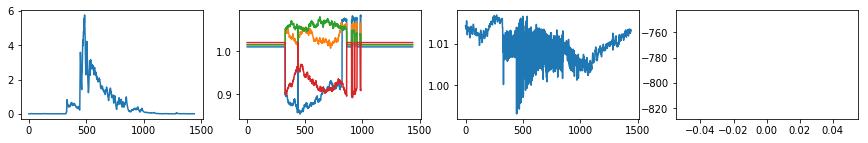

| Reward: -1001 | Episode: 1 | Qmax: 0.6904 | Action: [1.01  1.015 1.015 1.02 ]


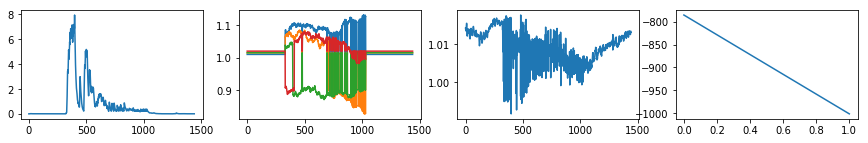

| Reward: -432 | Episode: 2 | Qmax: 0.6398 | Action: [1.01  1.015 1.015 1.02 ]


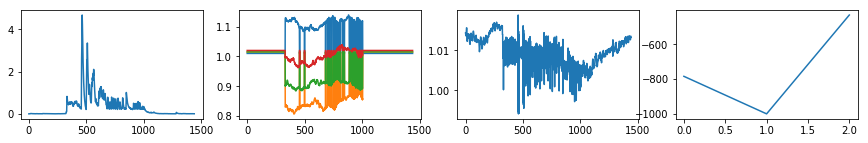

| Reward: -395 | Episode: 3 | Qmax: 0.6848 | Action: [1.01  1.015 1.015 1.02 ]


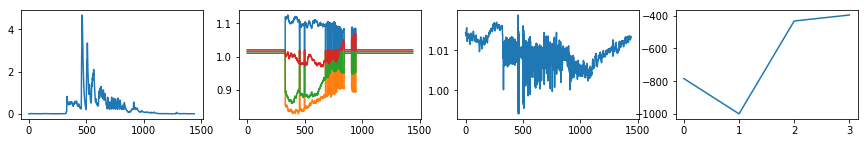

| Reward: -697 | Episode: 4 | Qmax: 1.4246 | Action: [1.01  1.015 1.015 1.02 ]


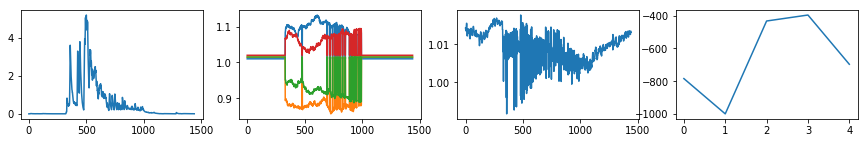

| Reward: -603 | Episode: 5 | Qmax: 1.8640 | Action: [1.01  1.015 1.015 1.02 ]


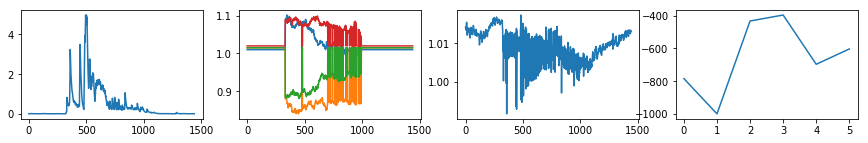

| Reward: -487 | Episode: 6 | Qmax: 1.8571 | Action: [1.01  1.015 1.015 1.02 ]


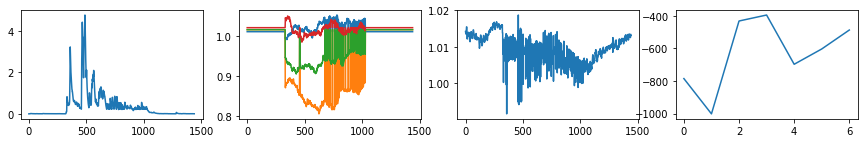

| Reward: -609 | Episode: 7 | Qmax: 1.7882 | Action: [1.01  1.015 1.015 1.02 ]


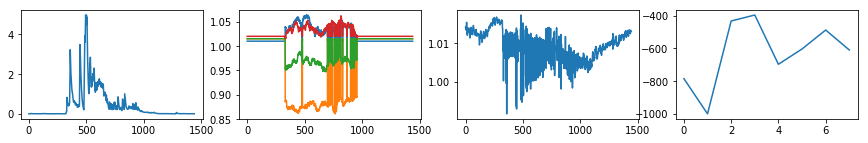

| Reward: -531 | Episode: 8 | Qmax: 1.6324 | Action: [1.01  1.015 1.015 1.02 ]


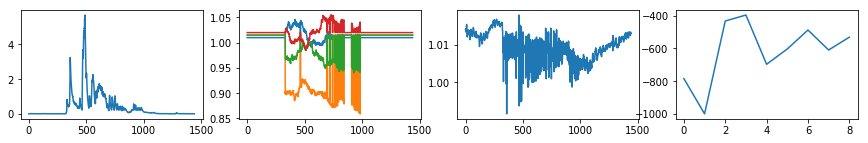

| Reward: -649 | Episode: 9 | Qmax: 1.4986 | Action: [1.01  1.015 1.015 1.02 ]


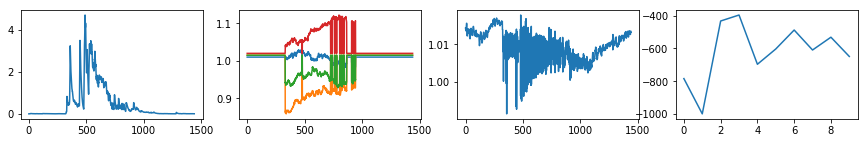

| Reward: -591 | Episode: 10 | Qmax: 1.4198 | Action: [1.01  1.015 1.015 1.02 ]


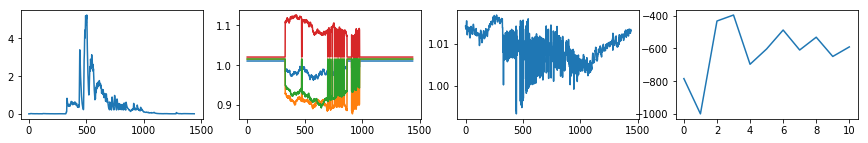

| Reward: -672 | Episode: 11 | Qmax: 1.3754 | Action: [1.01  1.015 1.015 1.02 ]


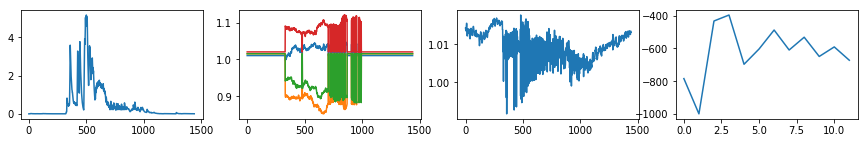

| Reward: -614 | Episode: 12 | Qmax: 1.3801 | Action: [1.01  1.015 1.015 1.02 ]


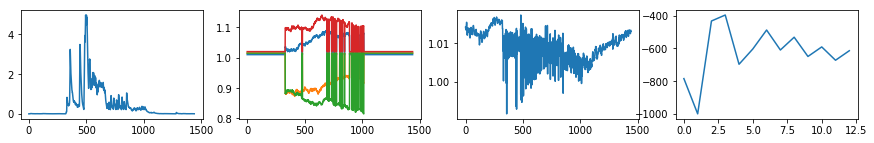

| Reward: -582 | Episode: 13 | Qmax: 1.5031 | Action: [1.01  1.015 1.015 1.02 ]


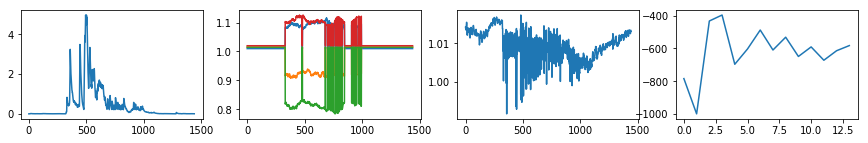

| Reward: -579 | Episode: 14 | Qmax: 1.6239 | Action: [1.01  1.015 1.015 1.02 ]


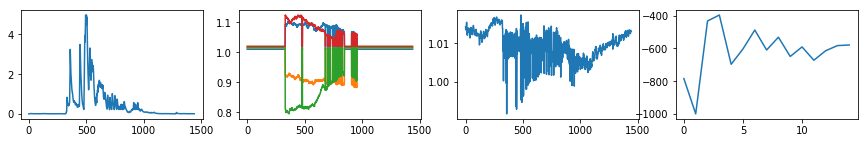

| Reward: -500 | Episode: 15 | Qmax: 1.6020 | Action: [1.01  1.015 1.015 1.02 ]


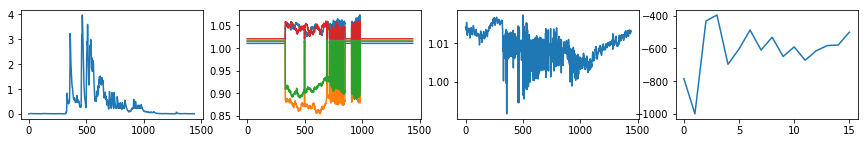

| Reward: -671 | Episode: 16 | Qmax: 1.5692 | Action: [1.01  1.015 1.015 1.02 ]


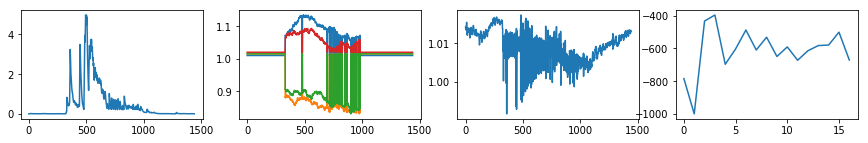

| Reward: -597 | Episode: 17 | Qmax: 1.5453 | Action: [1.01  1.015 1.015 1.02 ]


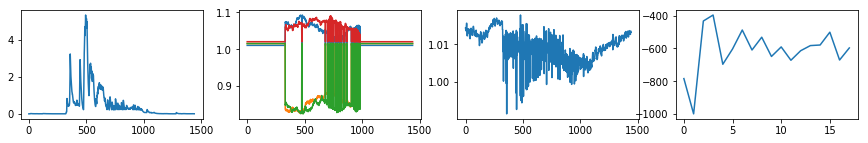

| Reward: -655 | Episode: 18 | Qmax: 1.6084 | Action: [1.01  1.015 1.015 1.02 ]


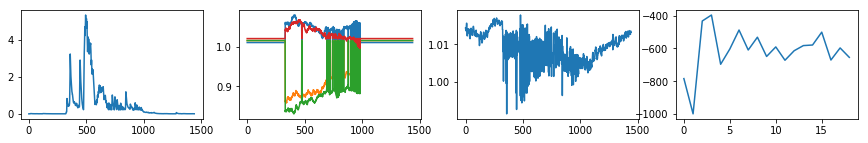

| Reward: -435 | Episode: 19 | Qmax: 1.7887 | Action: [1.01  1.015 1.015 1.02 ]


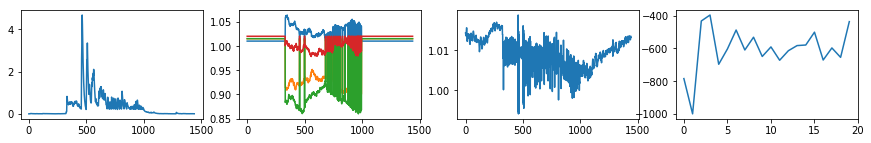

| Reward: -430 | Episode: 20 | Qmax: 2.1359 | Action: [1.01  1.015 1.015 1.02 ]


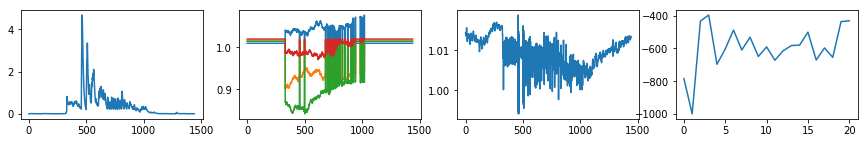

| Reward: -477 | Episode: 21 | Qmax: 2.0669 | Action: [1.01  1.015 1.015 1.02 ]


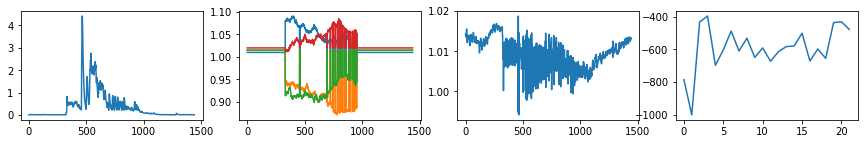

| Reward: -626 | Episode: 22 | Qmax: 2.1231 | Action: [1.01  1.015 1.015 1.02 ]


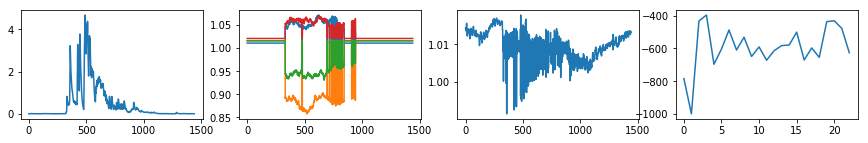

| Reward: -748 | Episode: 23 | Qmax: 2.1291 | Action: [1.01  1.015 1.015 1.02 ]


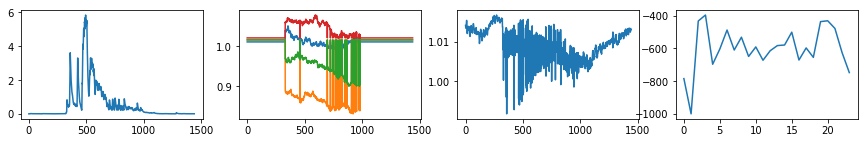

| Reward: -464 | Episode: 24 | Qmax: 2.1133 | Action: [1.01  1.015 1.015 1.02 ]


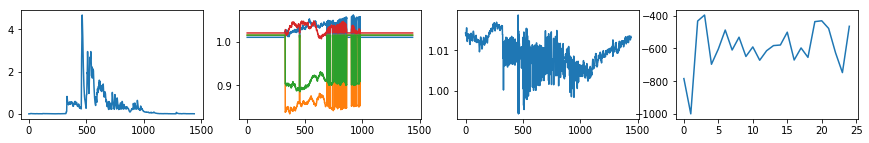

| Reward: -434 | Episode: 25 | Qmax: 2.1115 | Action: [1.01  1.015 1.015 1.02 ]


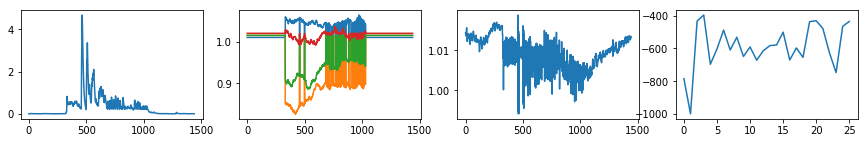

| Reward: -441 | Episode: 26 | Qmax: 2.1114 | Action: [1.01  1.015 1.015 1.02 ]


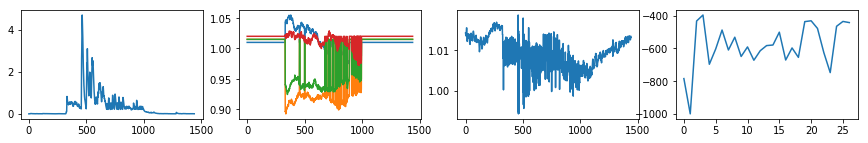

| Reward: -412 | Episode: 27 | Qmax: 2.1400 | Action: [1.01  1.015 1.015 1.02 ]


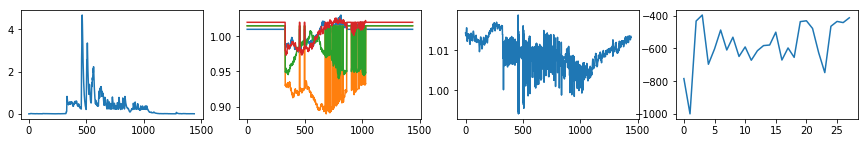

| Reward: -670 | Episode: 28 | Qmax: 2.1694 | Action: [1.01  1.015 1.015 1.02 ]


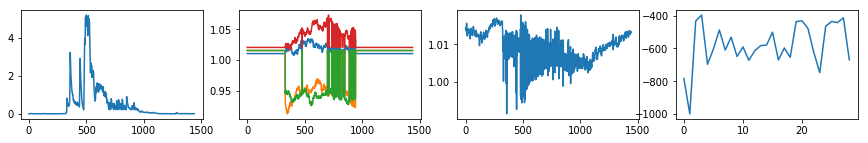

| Reward: -626 | Episode: 29 | Qmax: 2.2063 | Action: [1.01  1.015 1.015 1.02 ]


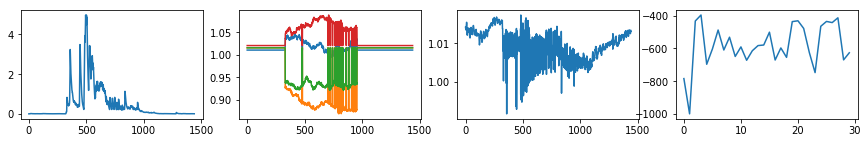

| Reward: -654 | Episode: 30 | Qmax: 2.2583 | Action: [1.01  1.015 1.015 1.02 ]


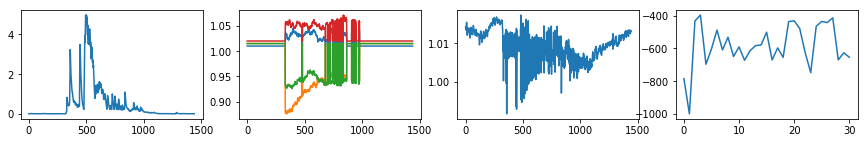

| Reward: -690 | Episode: 31 | Qmax: 2.1629 | Action: [1.01  1.015 1.015 1.02 ]


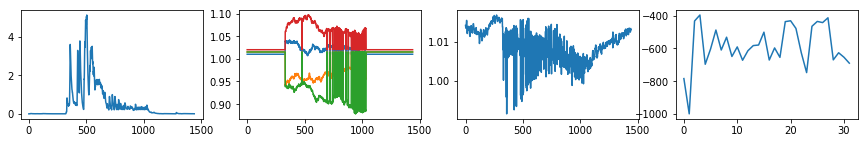

| Reward: -604 | Episode: 32 | Qmax: 2.2286 | Action: [1.01  1.015 1.015 1.02 ]


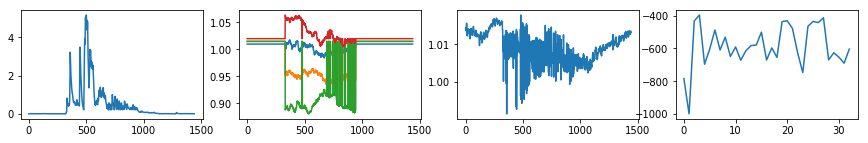

| Reward: -431 | Episode: 33 | Qmax: 2.2061 | Action: [1.01  1.015 1.015 1.02 ]


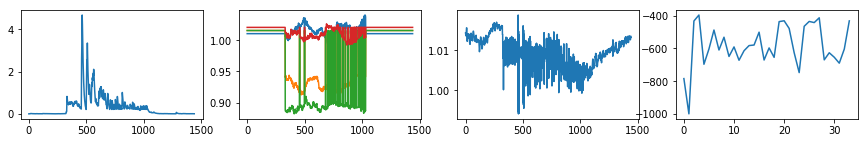

| Reward: -536 | Episode: 34 | Qmax: 2.2487 | Action: [1.01  1.015 1.015 1.02 ]


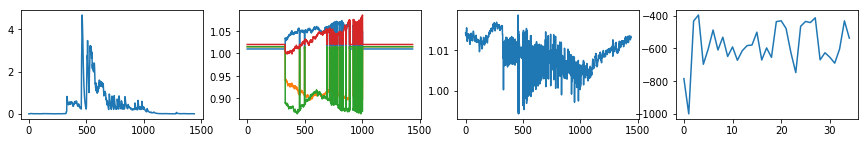

| Reward: -599 | Episode: 35 | Qmax: 2.1559 | Action: [1.01  1.015 1.015 1.02 ]


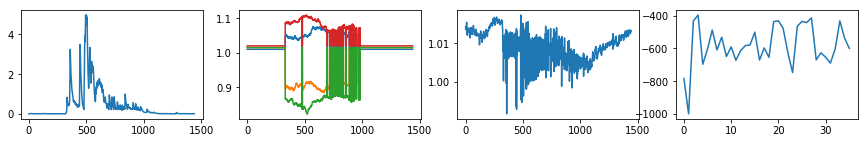

| Reward: -657 | Episode: 36 | Qmax: 2.1038 | Action: [1.01  1.015 1.015 1.02 ]


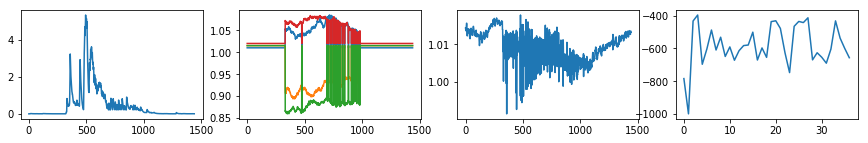

| Reward: -630 | Episode: 37 | Qmax: 2.0083 | Action: [1.01  1.015 1.015 1.02 ]


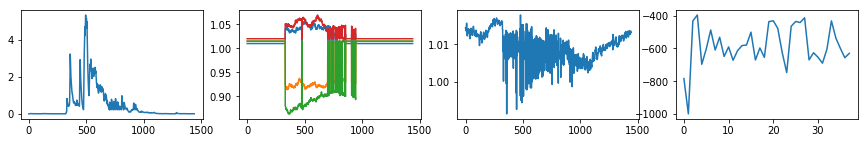

| Reward: -547 | Episode: 38 | Qmax: 2.0161 | Action: [1.01  1.015 1.015 1.02 ]


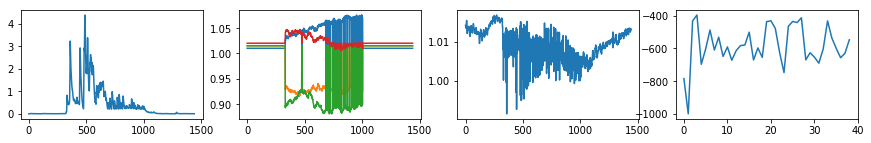

| Reward: -533 | Episode: 39 | Qmax: 1.9849 | Action: [1.01  1.015 1.015 1.02 ]


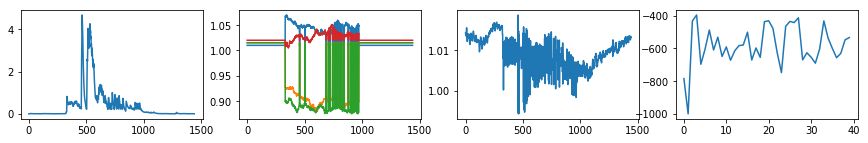

| Reward: -494 | Episode: 40 | Qmax: 1.9920 | Action: [1.01  1.015 1.015 1.02 ]


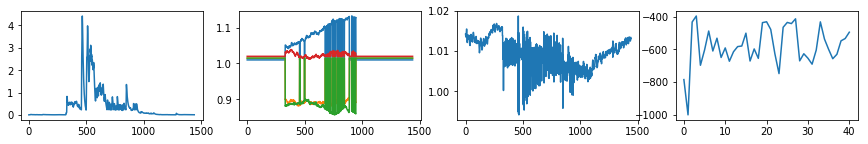

| Reward: -470 | Episode: 41 | Qmax: 2.0202 | Action: [1.01  1.015 1.015 1.02 ]


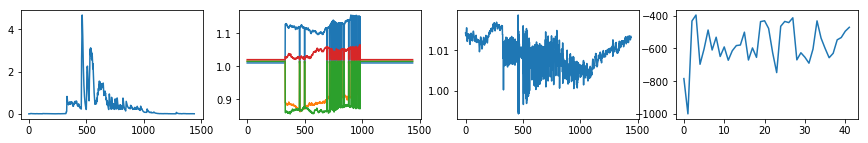

| Reward: -579 | Episode: 42 | Qmax: 2.0322 | Action: [1.01  1.015 1.015 1.02 ]


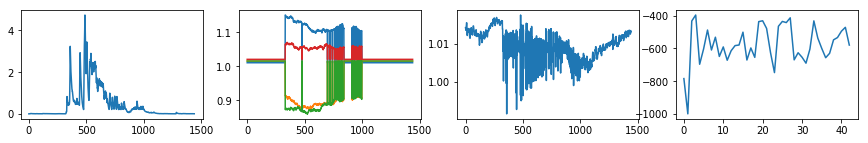

| Reward: -606 | Episode: 43 | Qmax: 2.1404 | Action: [1.01  1.015 1.015 1.02 ]


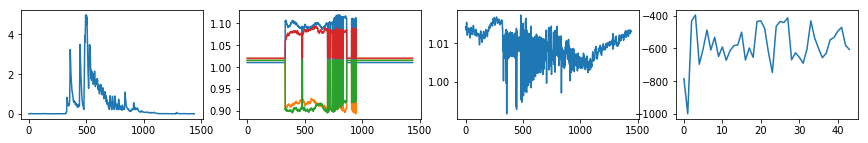

| Reward: -619 | Episode: 44 | Qmax: 2.2212 | Action: [1.01  1.015 1.015 1.02 ]


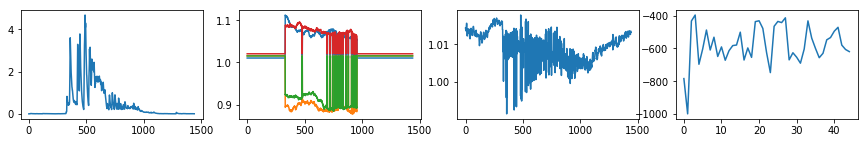

| Reward: -621 | Episode: 45 | Qmax: 2.5428 | Action: [1.01  1.015 1.015 1.02 ]


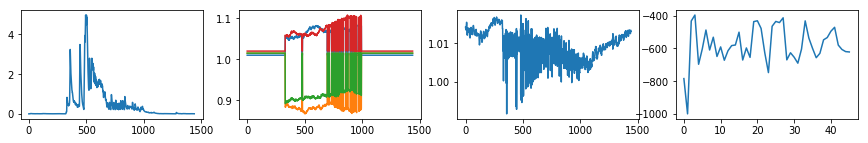

| Reward: -715 | Episode: 46 | Qmax: 2.7692 | Action: [1.01  1.015 1.015 1.02 ]


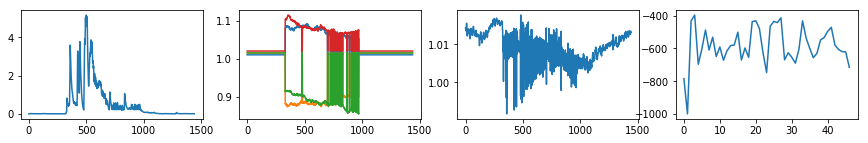

| Reward: -531 | Episode: 47 | Qmax: 2.8463 | Action: [1.01  1.015 1.015 1.02 ]


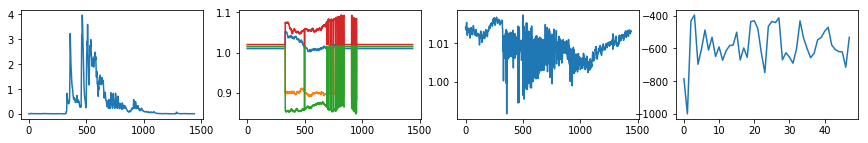

| Reward: -604 | Episode: 48 | Qmax: 3.2972 | Action: [1.01  1.015 1.015 1.02 ]


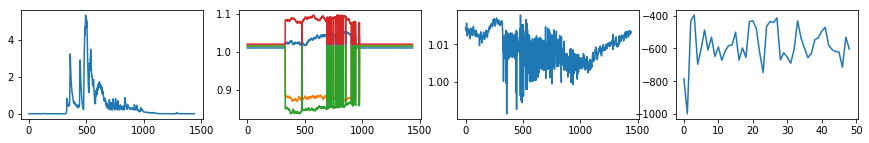

| Reward: -667 | Episode: 49 | Qmax: 3.8085 | Action: [1.01  1.015 1.015 1.02 ]


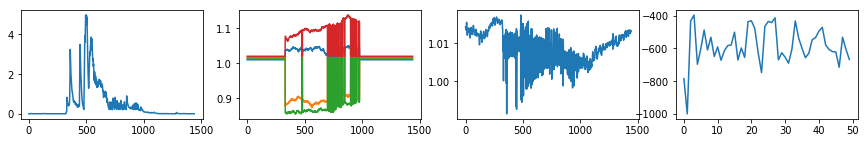

| Reward: -654 | Episode: 50 | Qmax: 4.6032 | Action: [1.01  1.015 1.015 1.02 ]


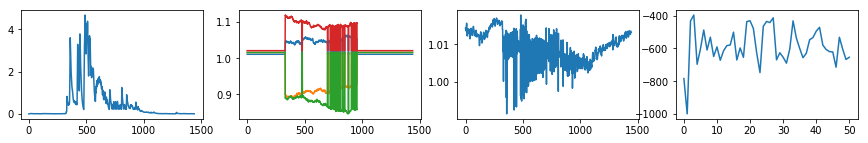

| Reward: -628 | Episode: 51 | Qmax: 4.7212 | Action: [1.01  1.015 1.015 1.02 ]


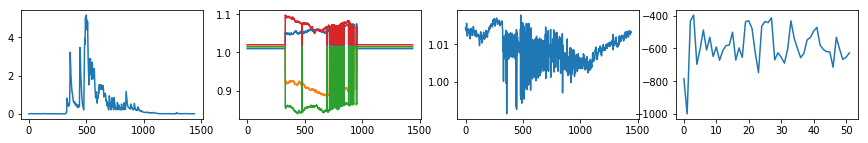

| Reward: -644 | Episode: 52 | Qmax: 4.7710 | Action: [1.01  1.015 1.015 1.02 ]


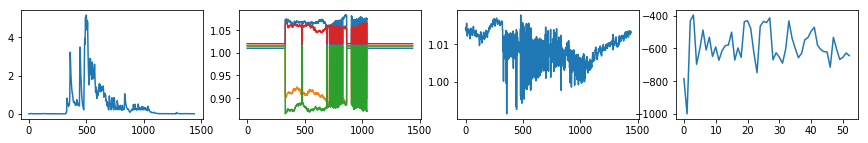

| Reward: -598 | Episode: 53 | Qmax: 4.8251 | Action: [1.01  1.015 1.015 1.02 ]


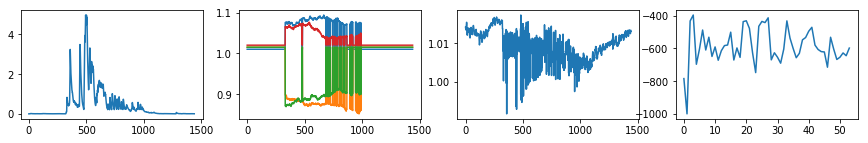

| Reward: -591 | Episode: 54 | Qmax: 4.7242 | Action: [1.01  1.015 1.015 1.02 ]


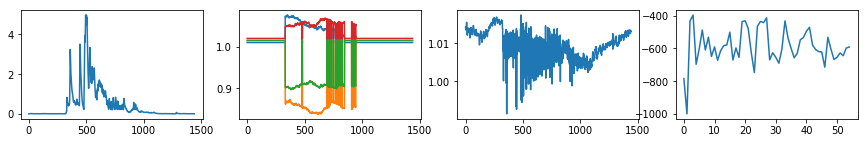

In [ ]:
import tensorflow as tf
import tflearn
import copy
args = {}
args['actor_lr'] = 0.0001
args['critic_lr'] = 0.001
args['gamma'] = 0.99
args['tau'] = 0.001
args['buffer_size'] = 5000
args['minibatch_size'] = 50
args['random_seed'] = 1234
args['max_episodes'] = 100
args['max_episode_len'] = TotalTimeSteps
args['summary_dir'] = os.getcwd()
args['random_seed'] = 1234
args['explore'] = 144100
#in this chapter, we only want to control 1 agent, other agents have a constant VBP
#agent 
agent = 2
#init action 
allAction = copy.deepcopy(VBP[:,:,0]) #need to run simulation
main(args)

for ksim in range(TotalTimeSteps):
    ############################################################
    ###############calculate new simulation#####################
    ############################################################
    #CALCULATE NET ZIP LOADS
    for node_iter in range(NumberOfLoads):
        knode = LoadList[node_iter]
        if ksim == 0:
            PowerEachTimeStep_vqvp[knode,:] = np.array([ZIP_demand[ksim,knode,0] - SolarGeneration_vqvp[ksim,knode],
                                                        ZIP_demand[ksim,knode,1],
                                                        ZIP_demand[ksim,knode,2]])
        else:
            PowerEachTimeStep_vqvp[knode,:] = np.array([ZIP_demand[ksim,knode,0] + InverterRealPower[ksim-1,knode]
                                                         + 1j*InverterReactivePower[ksim-1,knode], 
                                                        ZIP_demand[ksim,knode,1], 
                                                        ZIP_demand[ksim,knode,2]])
    #RUN FORWARD-BACKWARD SWEEP
    V_vqvp[:,ksim],S_vqvp[:,ksim] = FBSfun(V0[ksim,0],PowerEachTimeStep_vqvp,Z,FeederMap)
    
    #RUN INVERTER FUNCTION TO OUTPUT P/Q
    if (0 < ksim < TotalTimeSteps-1):
        for node_iter in range(NumberOfLoads):
            knode = LoadList[node_iter]
            InverterReactivePower[ksim,knode],InverterRealPower[ksim,knode],FilteredVoltage[ksim,knode],FilteredVoltageCalc[ksim,knode],_, _ = inverter_VoltVarVoltWatt_model(
                FilteredVoltage[ksim-1,knode], SolarGeneration_vqvp[ksim,knode], 
                abs(V_vqvp[knode,ksim]), abs(V_vqvp[knode,ksim-1]), 
                VBP[knode,:,ksim], TimeStep, InverterLPF, 
                Sbar[knode], InverterRealPower[ksim-1,knode], 
                InverterReactivePower[ksim-1,knode], InverterRateOfChangeLimit, 
                InverterRateOfChangeActivate, ksim, Delay_VoltageSampling[knode])
    
    #RUN OBSERVER FUNCTION
    for node_iter in range(NumberOfLoads):
        knode = LoadList[node_iter]
        if (ksim > 0):
            FilteredOutput_vqvp[ksim,knode],IntermediateOutput_vqvp[ksim,knode],Epsilon_vqvp[ksim,knode] = voltage_observer(V_vqvp[knode,ksim], V_vqvp[knode,ksim-1], 
                                                        IntermediateOutput_vqvp[ksim-1,knode], Epsilon_vqvp[ksim-1,knode], 
                                                        FilteredOutput_vqvp[ksim-1,knode], HighPassFilterFrequency, 
                                                        LowPassFilterFrequency, Gain_Energy, TimeStep)        
        